In [ ]:
!gdown 1iMtmU5ZiyolrFIlgOOosZL6tD31WaJ31

Downloading...
From: https://drive.google.com/uc?id=1iMtmU5ZiyolrFIlgOOosZL6tD31WaJ31
To: /content/NewPlantDiseasesDataset.zip
100% 1.45G/1.45G [00:14<00:00, 99.7MB/s]


In [ ]:
!unzip /content/NewPlantDiseasesDataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: New Plant Diseases Dataset(Augmented)/valid/Strawberry___healthy/19a8e3cb-c287-4871-9cb3-23e17fd5bf27___RS_HL 2160.JPG  
  inflating: New Plant Diseases Dataset(Augmented)/valid/Strawberry___healthy/1a119565-0295-4692-95cd-fbc32728f855___RS_HL 1853_new30degFlipLR.JPG  
  inflating: New Plant Diseases Dataset(Augmented)/valid/Strawberry___healthy/1a28038d-0e6d-4ac7-94d1-76d30fc89d71___RS_HL 2058_180deg.JPG  
  inflating: New Plant Diseases Dataset(Augmented)/valid/Strawberry___healthy/1b250776-ccb2-49b9-9964-a729567f60b9___RS_HL 2205_new30degFlipLR.JPG  
  inflating: New Plant Diseases Dataset(Augmented)/valid/Strawberry___healthy/1b9a47df-830d-4c52-b7e0-3180c8fee141___RS_HL 4482_180deg.JPG  
  inflating: New Plant Diseases Dataset(Augmented)/valid/Strawberry___healthy/1cb7b773-be85-4c1e-88b7-9a598089ebb0___RS_HL 1805_180deg.JPG  
  inflating: New Plant Diseases Dataset(Augmented)/valid/Strawberry___healthy/1e007f9a-6e90-4d

In [ ]:
import torch
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

# Define the transformations
train_transform = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

valid_transform = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Define the dataset objects
base_dir = '/content/New Plant Diseases Dataset(Augmented)/'
train_dataset = ImageFolder(root=base_dir+'/train', transform=train_transform)
valid_dataset = ImageFolder(root=base_dir+'/valid', transform=valid_transform)

# Define the data loaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)

class_names = train_dataset.classes

print("Number of classes:", len(class_names))
print("Class names:")
for name in class_names:
    print(name)


Number of classes: 38
Class names:
Apple___Apple_scab
Apple___Black_rot
Apple___Cedar_apple_rust
Apple___healthy
Blueberry___healthy
Cherry_(including_sour)___Powdery_mildew
Cherry_(including_sour)___healthy
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot
Corn_(maize)___Common_rust_
Corn_(maize)___Northern_Leaf_Blight
Corn_(maize)___healthy
Grape___Black_rot
Grape___Esca_(Black_Measles)
Grape___Leaf_blight_(Isariopsis_Leaf_Spot)
Grape___healthy
Orange___Haunglongbing_(Citrus_greening)
Peach___Bacterial_spot
Peach___healthy
Pepper,_bell___Bacterial_spot
Pepper,_bell___healthy
Potato___Early_blight
Potato___Late_blight
Potato___healthy
Raspberry___healthy
Soybean___healthy
Squash___Powdery_mildew
Strawberry___Leaf_scorch
Strawberry___healthy
Tomato___Bacterial_spot
Tomato___Early_blight
Tomato___Late_blight
Tomato___Leaf_Mold
Tomato___Septoria_leaf_spot
Tomato___Spider_mites Two-spotted_spider_mite
Tomato___Target_Spot
Tomato___Tomato_Yellow_Leaf_Curl_Virus
Tomato___Tomato_mosaic_viru

In [ ]:
import torch
import torch.nn as nn
from torchsummary import summary

VGG_types = {
    "VGG11": [64, "M", 128, "M", 256, 256, "M", 512, 512, "M", 512, 512, "M"],
    "VGG13": [64, 64, "M", 128, 128, "M", 256, 256, "M", 512, 512, "M", 512, 512, "M"],
    "VGG16": [
        64,
        64,
        "M",
        128,
        128,
        "M",
        256,
        256,
        256,
        "M",
        512,
        512,
        512,
        "M",
        512,
        512,
        512,
        "M",
    ],
    "VGG19": [
        64,
        64,
        "M",
        128,
        128,
        "M",
        256,
        256,
        256,
        256,
        "M",
        512,
        512,
        512,
        512,
        "M",
        512,
        512,
        512,
        512,
        "M",
    ],
}

class VGGnet(nn.Module):
    def __init__(self, in_channels=3, num_classes=38):
        super(VGGnet, self).__init__()
        self.in_channels = in_channels
        self.conv_layers = self.create_conv_layers(VGG_types["VGG19"])
        self.global_avg_pooling = nn.AdaptiveAvgPool2d(output_size=(1, 1))

        # Modify the fully connected layers to match the new input size
        self.fcs = nn.Sequential(
            nn.Linear(512*1*1, 4096),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.global_avg_pooling(x)
        x = x.view(x.size(0), -1)
        x = self.fcs(x)
        return x

    def create_conv_layers(self, architecture):
        layers = []
        in_channels = self.in_channels

        for x in architecture:
            if type(x) == int:
                out_channels = x

                layers += [
                    nn.Conv2d(
                        in_channels=in_channels,
                        out_channels=out_channels,
                        kernel_size=(3, 3),
                        stride=(1, 1),
                        padding=(1, 1),
                    ),
                    nn.BatchNorm2d(x),
                    nn.ReLU(),
                ]
                in_channels = x
            elif x == "M":
                layers += [nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2))]

        return nn.Sequential(*layers)

device = "cuda" if torch.cuda.is_available() else "cpu"
model = VGGnet(in_channels=3, num_classes=38).to(device)


freeze_layers = 5
for i, param in enumerate(model.parameters()):
    if i < freeze_layers:
        param.requires_grad = False

# Verify which layers are frozen
for name, param in model.named_parameters():
    if not param.requires_grad:
        print(f'Layer {name} is frozen.')

# Print model summary
summary(model.to(device), (3, 224, 224))  # Adjust input size as needed


Layer conv_layers.0.weight is frozen.
Layer conv_layers.0.bias is frozen.
Layer conv_layers.1.weight is frozen.
Layer conv_layers.1.bias is frozen.
Layer conv_layers.3.weight is frozen.
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
       BatchNorm2d-2         [-1, 64, 224, 224]             128
              ReLU-3         [-1, 64, 224, 224]               0
            Conv2d-4         [-1, 64, 224, 224]          36,928
       BatchNorm2d-5         [-1, 64, 224, 224]             128
              ReLU-6         [-1, 64, 224, 224]               0
         MaxPool2d-7         [-1, 64, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]          73,856
       BatchNorm2d-9        [-1, 128, 112, 112]             256
             ReLU-10        [-1, 128, 112, 112]               0
           Conv2d-11        [-1, 128, 112, 11

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import os

# Set a directory to save the model checkpoints
checkpoint_dir = 'checkpoints'
os.makedirs(checkpoint_dir, exist_ok=True)

# Define hyperparameters
learning_rate = 0.01
num_epochs = 5  # Adjust as needed

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate)


best_val_accuracy = 0.0

# Training loop
for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    running_loss = 0.0
    correct_predictions = 0
    total_samples = 0

    # Iterate through the training data
    for images, labels in tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}'):
        images, labels = images.to(device), labels.to(device)

        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backpropagation
        loss.backward()
        optimizer.step()

        # Update statistics
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_samples += labels.size(0)
        correct_predictions += (predicted == labels).sum().item()

    # Calculate training loss and accuracy
    train_loss = running_loss / len(train_loader)
    train_accuracy = 100 * correct_predictions / total_samples

    # Validation loop
    model.eval()  # Set the model to evaluation mode
    val_loss = 0.0
    correct_predictions = 0
    total_samples = 0

    with torch.no_grad():
        for images, labels in tqdm(valid_loader, desc='Validation'):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_samples += labels.size(0)
            correct_predictions += (predicted == labels).sum().item()

    # Calculate validation loss and accuracy
    val_loss /= len(valid_loader)
    val_accuracy = 100 * correct_predictions / total_samples

    # Display progress
    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%")

    # Save the model checkpoint if validation accuracy improves
    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        checkpoint_path = os.path.join(checkpoint_dir, f"best_model_epoch_{epoch+1}.pt")
        torch.save(model.state_dict(), checkpoint_path)
        print(f"Saved best model checkpoint at {checkpoint_path}")

print("Training complete.")


Validation: 100%|██████████| 550/550 [02:29<00:00,  3.69it/s]


Epoch 1/5, Train Loss: 1.2699, Train Accuracy: 63.20%, Val Loss: 0.3803, Val Accuracy: 87.37%
Saved best model checkpoint at checkpoints/best_model_epoch_1.pt


Validation: 100%|██████████| 550/550 [02:30<00:00,  3.67it/s]


Epoch 2/5, Train Loss: 0.2824, Train Accuracy: 91.06%, Val Loss: 0.1223, Val Accuracy: 95.90%
Saved best model checkpoint at checkpoints/best_model_epoch_2.pt


Validation: 100%|██████████| 550/550 [02:30<00:00,  3.66it/s]


Epoch 3/5, Train Loss: 0.1561, Train Accuracy: 94.99%, Val Loss: 0.1267, Val Accuracy: 95.77%


Validation: 100%|██████████| 550/550 [02:29<00:00,  3.68it/s]


Epoch 4/5, Train Loss: 0.1053, Train Accuracy: 96.60%, Val Loss: 0.0484, Val Accuracy: 98.39%
Saved best model checkpoint at checkpoints/best_model_epoch_4.pt


Validation: 100%|██████████| 550/550 [02:29<00:00,  3.67it/s]


Epoch 5/5, Train Loss: 0.0800, Train Accuracy: 97.42%, Val Loss: 0.0460, Val Accuracy: 98.51%
Saved best model checkpoint at checkpoints/best_model_epoch_5.pt
Training complete.


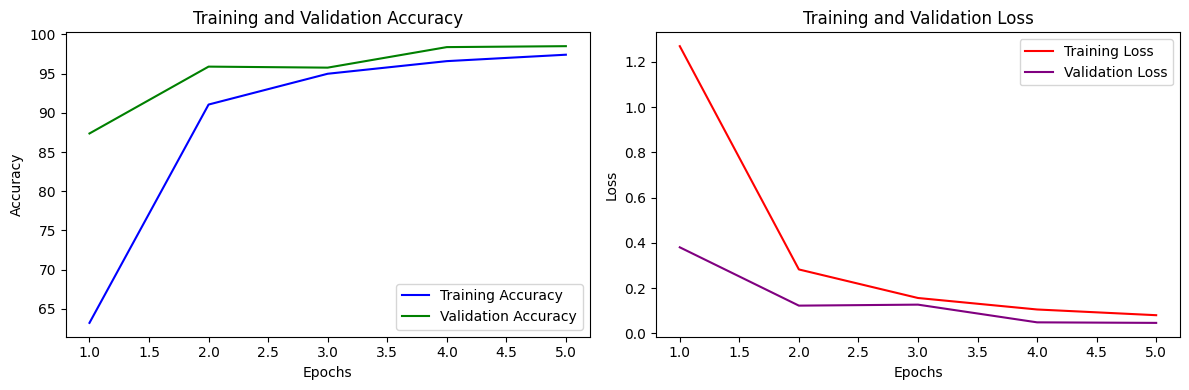

In [ ]:
import matplotlib.pyplot as plt

train_accuracies = [63.20,91.06,94.99,96.60,97.42]  # List of training accuracies for each epoch
val_accuracies = [87.37,95.90,95.77,98.39,98.51]    # List of validation accuracies for each epoch
train_losses = [1.2699,0.2824,0.1561,0.1053,0.0800]      # List of training losses for each epoch
val_losses = [0.3803,0.1223,0.1267,0.0484,0.0460]        # List of validation losses for each epoch

# Generate a list of epochs
epochs = range(1, num_epochs + 1)

# Plotting accuracy
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_accuracies, label='Training Accuracy', color='blue')
plt.plot(epochs, val_accuracies, label='Validation Accuracy', color='green')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

# Plotting loss
plt.subplot(1, 2, 2)
plt.plot(epochs, train_losses, label='Training Loss', color='red')
plt.plot(epochs, val_losses, label='Validation Loss', color='purple')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.tight_layout()
plt.show()


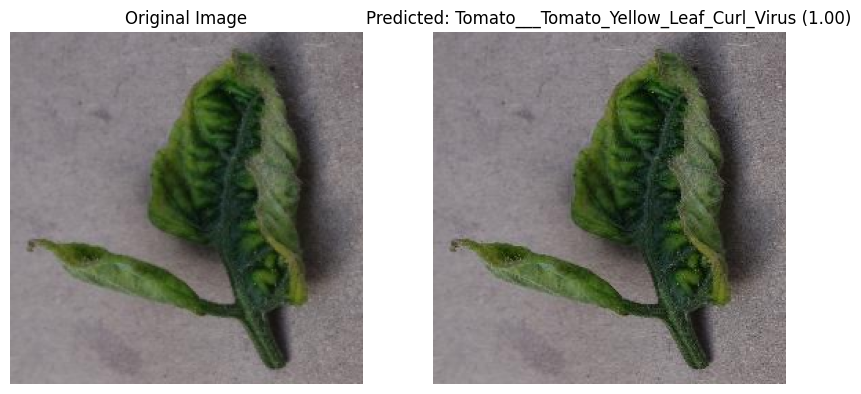

In [ ]:
import torch
import torch.nn.functional as F
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

# Define the path to the single test image you want to test
single_test_image_path = '/content/New Plant Diseases Dataset(Augmented)/test/test/TomatoYellowCurlVirus3.JPG'

# Define the transformation for the single test image
test_transform = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Load the single test image and apply the transformation
single_test_image = Image.open(single_test_image_path).convert('RGB')
input_image = test_transform(single_test_image).unsqueeze(0)  # Add a batch dimension

# Load the trained model
model = VGGnet(in_channels=3, num_classes=38)
model.load_state_dict(torch.load('/content/checkpoints/best_model_epoch_5.pt'))
model.eval()  # Set the model to evaluation mode

# Perform prediction
with torch.no_grad():
    output = model(input_image)

# Get predicted class and confidence
predicted_class = torch.argmax(output, dim=1).item()
confidence = F.softmax(output, dim=1)[0][predicted_class].item()
predicted_class_name = class_names[predicted_class]

# Convert the input and predicted images to NumPy arrays
input_image_np = input_image.squeeze(0).permute(1, 2, 0).numpy()
input_image_np = (input_image_np * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])).clip(0, 1)  # Reverse normalization

# Display the original and predicted images
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.set_title('Original Image')
ax1.imshow(input_image_np)
ax1.axis('off')

ax2.set_title(f'Predicted: {predicted_class_name} ({confidence:.2f})')
ax2.imshow(single_test_image)
ax2.axis('off')

plt.show()


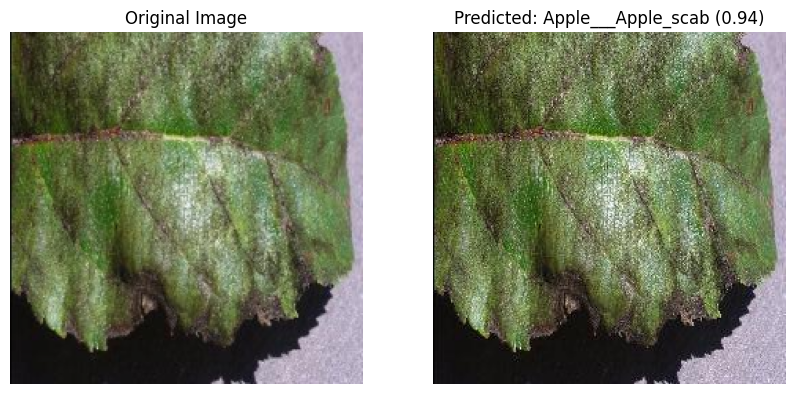

In [ ]:
import torch
import torch.nn.functional as F
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

# Define the path to the single test image you want to test
single_test_image_path = '/content/New Plant Diseases Dataset(Augmented)/test/test/AppleScab3.JPG'

# Define the transformation for the single test image
test_transform = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Load the single test image and apply the transformation
single_test_image = Image.open(single_test_image_path).convert('RGB')
input_image = test_transform(single_test_image).unsqueeze(0)  # Add a batch dimension

# Load the trained model
model = VGGnet(in_channels=3, num_classes=38)
model.load_state_dict(torch.load('/content/checkpoints/best_model_epoch_5.pt'))
model.eval()  # Set the model to evaluation mode

# Perform prediction
with torch.no_grad():
    output = model(input_image)

# Get predicted class and confidence
predicted_class = torch.argmax(output, dim=1).item()
confidence = F.softmax(output, dim=1)[0][predicted_class].item()
predicted_class_name = class_names[predicted_class]

# Convert the input and predicted images to NumPy arrays
input_image_np = input_image.squeeze(0).permute(1, 2, 0).numpy()
input_image_np = (input_image_np * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])).clip(0, 1)  # Reverse normalization

# Display the original and predicted images
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.set_title('Original Image')
ax1.imshow(input_image_np)
ax1.axis('off')

ax2.set_title(f'Predicted: {predicted_class_name} ({confidence:.2f})')
ax2.imshow(single_test_image)
ax2.axis('off')

plt.show()


In [ ]:
import torch
import torch.nn as nn
from torchvision import models
from torch.utils.data import DataLoader
from sklearn.metrics import classification_report
from tqdm import tqdm
import os

checkpoint_path = '/content/checkpoints/best_model_epoch_5.pt'
checkpoint = torch.load(checkpoint_path)
model.load_state_dict(checkpoint)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()  # Set the model to evaluation mode

# Initialize variables for storing true labels and predicted labels
true_labels = []
predicted_labels = []

with torch.no_grad():
    for images, labels in tqdm(valid_loader, desc='Validation', total=len(valid_loader)):
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)

        # Append true and predicted labels
        true_labels.extend(labels.cpu().numpy())
        predicted_labels.extend(predicted.cpu().numpy())

# Generate the classification report
class_names = train_dataset.classes
report = classification_report(true_labels, predicted_labels, target_names=class_names)




Validation: 100%|██████████| 550/550 [02:29<00:00,  3.67it/s]


In [ ]:
print(report)

                                                    precision    recall  f1-score   support

                                Apple___Apple_scab       1.00      0.99      0.99       504
                                 Apple___Black_rot       1.00      1.00      1.00       497
                          Apple___Cedar_apple_rust       0.99      0.99      0.99       440
                                   Apple___healthy       0.98      1.00      0.99       502
                               Blueberry___healthy       0.99      1.00      0.99       454
          Cherry_(including_sour)___Powdery_mildew       1.00      0.99      1.00       421
                 Cherry_(including_sour)___healthy       1.00      0.99      0.99       456
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot       0.99      0.85      0.91       410
                       Corn_(maize)___Common_rust_       1.00      0.99      0.99       477
               Corn_(maize)___Northern_Leaf_Blight       0.88      1.00      0.